<a href="https://colab.research.google.com/github/santoreb/Image_Classification_ChestXray_Gender_Prediction/blob/main/Train_Small_Model_2_Gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, models
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score, roc_curve, auc

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# from google.colab import files
# uploaded = files.upload()

from zipfile import ZipFile
file_name = "/content/Gender01_RGB.zip"

with ZipFile(file_name, 'r') as zipfile:
  zipfile.extractall()
  print('Done')

transform = ToTensor()

train_data = datasets.ImageFolder(root = "/content/Gender01_RGB/train", transform=transform)
test_data = datasets.ImageFolder(root = "/content/Gender01_RGB/test", transform=transform)

print(train_data)
print(test_data)

Done
Dataset ImageFolder
    Number of datapoints: 154
    Root location: /content/Gender01_RGB/train
    StandardTransform
Transform: ToTensor()
Dataset ImageFolder
    Number of datapoints: 93
    Root location: /content/Gender01_RGB/test
    StandardTransform
Transform: ToTensor()


torch.Size([3, 256, 256])
tensor(1)


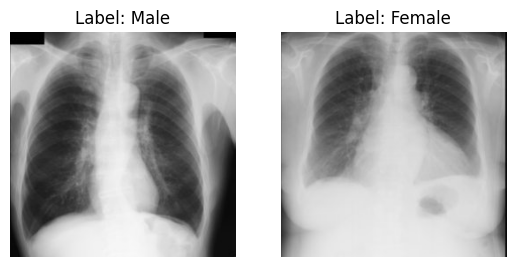

In [19]:
# Assuming you have a dataset 'dataset' with labels 'labels'
labels_train = torch.Tensor(train_data.targets).int()
class_counts = torch.bincount(labels_train)
class_weights = 1. / class_counts.float()

# Create a sampler
weights_train = class_weights[labels_train]
sampler_train = WeightedRandomSampler(weights_train, len(weights_train))

# labels_test = torch.Tensor(test_data.targets).int()
# class_counts = torch.bincount(labels_test)
# class_weights = 1. / class_counts.float()

# # Create a sampler
# weights_test = class_weights[labels_test]
# sampler_test = WeightedRandomSampler(weights_test, len(weights_test))

loaders = {
    'train': torch.utils.data.DataLoader(train_data,
                                         batch_size=5,
                                         shuffle = False,
                                         num_workers=1,
                                         sampler=sampler_train),
    'test':  torch.utils.data.DataLoader(test_data,
                                         batch_size=93,
                                         shuffle = False,
                                         num_workers=1),
}
loaders

# Get a batch of images and labels
images, labels = next(iter(loaders['train']))

print(images[0].shape)
print(labels[0])

# Visualize the images
fig, axs = plt.subplots(1, 2)
for i in range(2):
    axs[i].imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) format
    axs[i].set_title(f"Label: {'Male' if labels[i] == 1 else 'Female'}")
    axs[i].axis('off')

plt.show()

In [3]:
model = models.resnet18(pretrained=True)
model

num_features = model.fc.in_features
print('Number of features from pre-trained model', num_features)

model.fc = nn.Linear(num_features, 2)
model = model.to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 75.2MB/s]


Number of features from pre-trained model 512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = 0.01)

num_epochs = 100

def train(num_epochs, model, loaders):
  model.train()
  total_step = len(loaders['train'])

  for epoch in range(num_epochs):
    for i, (images,labels) in enumerate(loaders['train']):
      b_x = Variable(images)
      b_y = Variable(labels)
      b_x = b_x.to(device)
      b_y = b_y.to(device)
      output = model(b_x)
      loss = loss_func(output, b_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if (i+1) % 10 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i+1, total_step, loss.item()))
        pass
    pass
  pass
train(num_epochs, model, loaders)

Epoch [1/100], Step [10/31], Loss: 0.6341
Epoch [1/100], Step [20/31], Loss: 1.6058
Epoch [1/100], Step [30/31], Loss: 0.9446
Epoch [2/100], Step [10/31], Loss: 0.3590
Epoch [2/100], Step [20/31], Loss: 0.6664
Epoch [2/100], Step [30/31], Loss: 0.1743
Epoch [3/100], Step [10/31], Loss: 0.5639
Epoch [3/100], Step [20/31], Loss: 1.8015
Epoch [3/100], Step [30/31], Loss: 1.1717
Epoch [4/100], Step [10/31], Loss: 0.5904
Epoch [4/100], Step [20/31], Loss: 0.3723
Epoch [4/100], Step [30/31], Loss: 0.5393
Epoch [5/100], Step [10/31], Loss: 0.3174
Epoch [5/100], Step [20/31], Loss: 0.5195
Epoch [5/100], Step [30/31], Loss: 0.2401
Epoch [6/100], Step [10/31], Loss: 1.9611
Epoch [6/100], Step [20/31], Loss: 0.6036
Epoch [6/100], Step [30/31], Loss: 0.3678
Epoch [7/100], Step [10/31], Loss: 0.4301
Epoch [7/100], Step [20/31], Loss: 0.4611
Epoch [7/100], Step [30/31], Loss: 0.5441
Epoch [8/100], Step [10/31], Loss: 0.4770
Epoch [8/100], Step [20/31], Loss: 0.4670
Epoch [8/100], Step [30/31], Loss:

Test Accuracy of the model on the 93 test images: 0.83


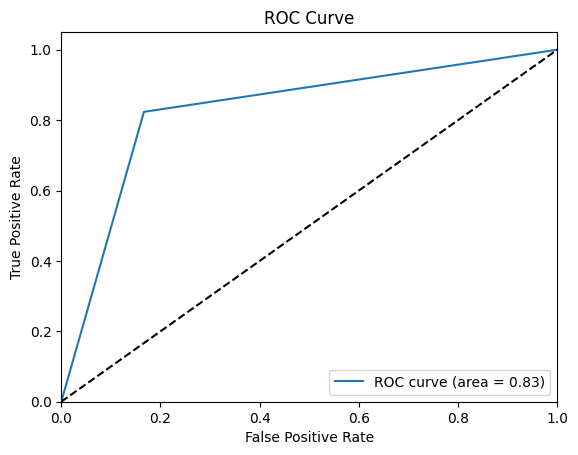

Total AUC:  0.8284313725490196


In [18]:
def test():
  model.eval()

  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loaders['test']:
      images = images.to(device)
      labels = labels.to(device)
      test_output = model(images)
      pred_y = torch.max(test_output, 1)[1].data.squeeze()
      accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
      print(f"Test Accuracy of the model on the {loaders['test'].batch_size} test images: {accuracy:.2f}")
      roc_auc = roc_auc_score(labels.to('cpu'), pred_y.to('cpu'))
      fpr, tpr, _ = roc_curve(labels.to('cpu'), pred_y.to('cpu'))

      plt.figure()
      plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC Curve')
      plt.legend(loc="lower right")
      plt.show()
      print("Total AUC: ", roc_auc)
test()